# Semestrální práce - analýza datasetu **eurosat**

Tato semestrální práce se zabývá analýzou datasetu eurosat. Cílem je vytvořit několik odlišných architektur neuronových sítí a zvolený dataset na nich natrénovat. Pro účely této práce byly vybrány celkem 4 architektury neuronových sítí:
*   Vícevrstvý perceptron (A0)
*   Základní konvoluční neuronová síť (A1)
*   Konvoluční neuronová síť s obohacením dat (A2)
*   Konvoluční neuronová síť s přeneseným učením (A3)

Dataset eurosat je určen pro úlohu klasifikace obrázků, tudíž hlavním cílem této práce je porovnat jednotlivé architektury konvolučních neuronových sítí. Vícevrstvý perceptron bude využit pouze jako základní bod výzkumu a nebudou u něj prováděny další úpravy a experimenty (proto je označen jako A0).

Každá architektura bude obsahovat vytvoření modelu, trénování modelu, vizualizaci trénování a evaluaci modelu. V rámci architektur budou také prováděny různé experimenty pomocí ladění hyperparametrů. Jednotlivé výsledky budou zaznamenány do odpovídajích tabulek. V závěru práce budou všechny výsledky shrnuty.

---

* Bc. David Poslušný
* 4IZ561 -	Umělé neuronové sítě
* ZS 2023/2024


## Popis datasetu

Dataset EuroSAT je založen na snímcích družice Sentinel-2, které pokrývají 13 spektrálních pásem a skládají se z **10 tříd** s **27 000** označenými a georeferencovanými vzorky. Nabízeny jsou dvě verze této datové sady:
* **eurosat/rgb** - obsahuje pouze optická frekvenční pásma R, G, B zakódována ve formátu JPEG. Jedná se také o defaultní variantu.
* **eurosat/all** - obsahuje všech 13 pásem v původním rozsahu hodnot (float32)



https://www.tensorflow.org/datasets/catalog/eurosat


V případě této semestrální práce se bude pracovat se základní variantou **eurosat/rgb**.

## Popis řešené úlohy

Zpracovávaná úloha je klasifikace obrázků. Cílem úlohy je přiřadit obrázek do jedné z 10 možných tříd. Jedná se tedy o vícetřídní klasifikaci. Dataset obsahuje barevné obrázky 64x64 pixelů v 3 barevných kanálech. Barevné obrázky lze reprezentovat jako 3D tenzor - výška x šířka x hloubka.

Tenzor, který tedy bude nutné zpracovat při této úloze je `(64, 64, 3)`.

Při úloze bude měřena metrika **správnosti (accuracy)**, která udává poměr správně klasifikovaných případů ku všem klasifikovaným případům.

## Načtení a rozdělní dat


Načtení Python knihoven pro práci.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

Data načteme přímo z knihovny tensorflow_datasets pomocí funkce `tfds.load` do objektu `tf.data.Dataset`. Dataset euroSAT obsahuje celkem 27 000 satelitních snímků. Pro klasifikaci je nutné data rozdělit na tři množiny:
* trénovací
* validační
* testovací

Rozdělení dat:
* **70 %** - trénování - 18 900 případů
* **15%** - validace - 4 050 případů
* **15 %** - testování - 4 050 případů

https://www.tensorflow.org/datasets/api_docs/python/tfds/load

In [4]:
(train_set, validation_set, test_set), info = tfds.load(
    'eurosat',
    split=['train[:18900]', 'train[18900:22950]', 'train[22950:27000]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteKMPH6L/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


## Průzkum dat

Tato kapitola obsahuje zkoumání a analýzu dat.

### Ukázka vstupních dat

Funkce `tfds.show_examples` umožňuje vizualizovat obrázky a jejich labely ze souboru dat pro klasifikaci obrázků.

https://www.tensorflow.org/datasets/api_docs/python/tfds/visualization/show_examples

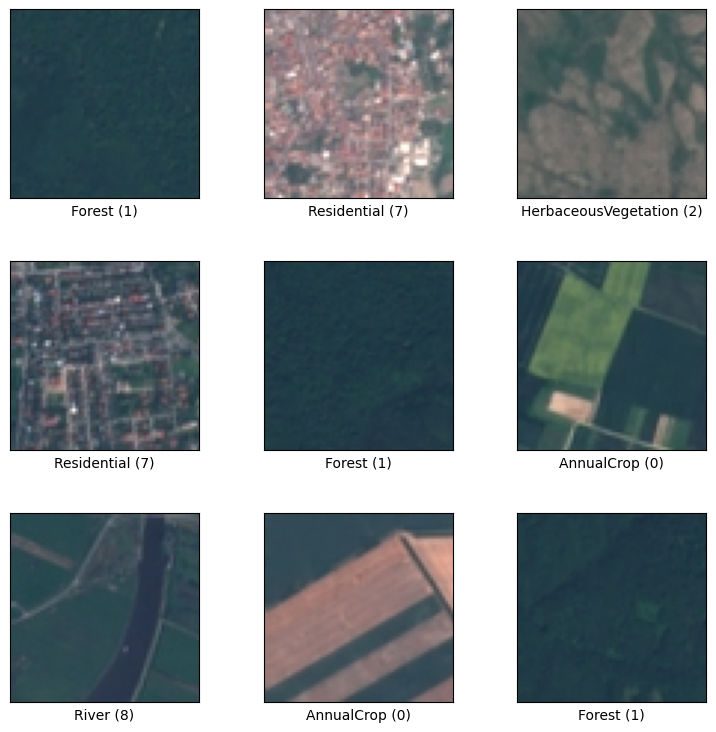

In [5]:
# Ukázka vzorku obrázků z trénovací množiny
fig = tfds.show_examples(train_set, info)

### Vizualizace rozdělení tříd v trénovací množině

In [6]:
# Extrakce a výpis názvů jednotlivých tříd z objektu 'info', který obsahuje informace o datasetu
class_names = info.features['label'].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [8]:
# Iterace přes celou trénovací množinu - pro každý obrázek se uloží do pole jeho label ve formě čísla (0-9)
train_labels = []
for _, label in tfds.as_numpy(train_set):
    train_labels.append(label)

# Iterace přes všechny labely trénovací množiny:
# pro každou hodnotu labelu se získá odpovídající název třídy pomocí indexu v seznamu 'class_names' a pro danou třídu se zvýší počet výskytů
label_counts = {}
for label in train_labels:
    label_name = class_names[label]
    label_counts[label_name] = label_counts.get(label_name, 0) + 1

In [9]:
# Výpis počtu příkladů pro jednotlivé labely
print(label_counts)

{'Forest': 2143, 'Residential': 2095, 'HerbaceousVegetation': 2067, 'AnnualCrop': 2122, 'River': 1754, 'Industrial': 1756, 'Pasture': 1382, 'SeaLake': 2107, 'PermanentCrop': 1718, 'Highway': 1756}


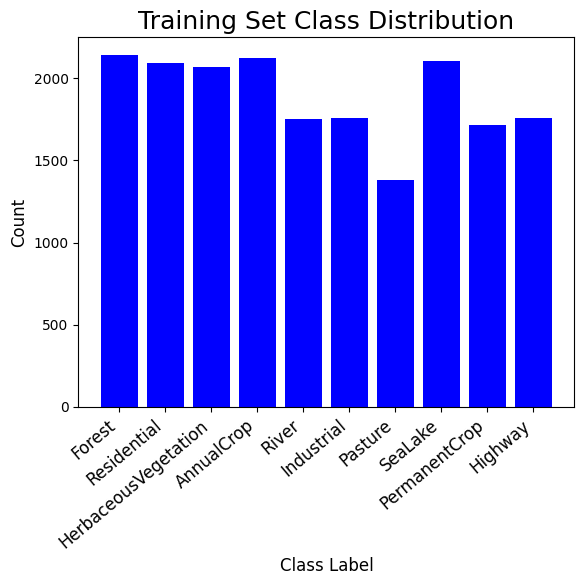

In [ ]:
# Vizualizace distribuce tříd pomocí sloupcového grafu
plt.bar(list(label_counts.keys()), list(label_counts.values()), color='blue')
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Training Set Class Distribution', fontsize=18)
plt.xticks(rotation=40, fontsize=12, ha='right')
plt.show()

Z grafu lze vidět, že distribuce je až na pár odchylek v celku rovnoměrná a každá třída je v trénovací množině dostatečně zastoupena. Množina je tedy vhodná pro trénování neuronových sítí.

In [ ]:
# Maximální a minimální hodnota ze slovníku 'label_counts'
max_label = max(label_counts, key=label_counts.get)
min_label = min(label_counts, key=label_counts.get)

print(f"Nejvíce hodnot má třída '{max_label}' s počtem {label_counts[max_label]}.")
print(f"Nejméně hodnot má třída '{min_label}' s počtem {label_counts[min_label]}.")

Nejvíce hodnot má třída 'Forest' s počtem 2143.
Nejméně hodnot má třída 'Pasture' s počtem 1382.


V datasetu jsou nejméně zastoupeny satelitní snímky typu 'Pasture', těch je v datasetu pouze 1382.

## Předzpracování dat

V rámci předzpracování jednotlivých datových množin byly provedeny tyto kroky:
* **shuffling** - zamíchání celé trénovací množiny
* **rescaling** - převod obrázku na float32 tenzor
* **batching** - rozdělení množiny do dávek
* **prefetching** - načtení dat během trénování pro lepší výkon


https://www.tensorflow.org/api_docs/python/tf/cast

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.tensorflow.org/guide/data_performance

Není nutná změna velikosti obrázků, všechny mají velikost 64x64 pixelů (viz. dokumentace datasetu)

In [ ]:
# Konstanta pro optimalizaci výkonu předzpracováním datasetu
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128

# Převod obrázku na float32 tenzor
def rescale(image, label):
  image = tf.cast(image, tf.float32)
  return image, label

In [ ]:
# Trénovací množina se navíc zamíchá
train_set = (
    train_set
    .shuffle(18900)
    .map(rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

validation_set = (
    validation_set
    .map(rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_set = (
    test_set
    .map(rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
# Tenzor 1 dávky - kontrolní výpis
def check_image_shape(dataset):
    for image, label in dataset.take(1):
        return image.shape

print(check_image_shape(train_set))

(128, 64, 64, 3)


In [ ]:
# Výběr jednoho příkladu z trénovací množiny - kontrolní výpis
for image, label in train_set.take(1):
  # Výpis všech labelů v dávce (128)
  print(label)
  # Výpis jednoho tenzoru z dávky
  print(image[0])

tf.Tensor(
[6 9 2 6 0 7 1 6 3 5 9 4 7 9 6 3 3 2 9 5 8 5 2 3 7 7 3 3 8 6 0 1 0 0 4 1 0
 6 5 9 3 2 8 0 7 1 9 6 7 1 9 7 1 2 3 0 3 1 4 8 3 0 2 9 2 2 5 2 8 3 3 0 2 4
 7 1 6 2 0 7 2 1 6 2 9 3 1 8 3 5 7 0 7 2 1 2 6 6 3 7 4 6 3 9 3 9 9 5 1 8 6
 9 0 7 1 0 8 6 4 4 4 9 4 7 4 1 8 1], shape=(128,), dtype=int64)
tf.Tensor(
[[[ 61. 103.  93.]
  [ 62. 102.  93.]
  [ 65. 102.  94.]
  ...
  [ 67.  76.  81.]
  [ 70.  75.  81.]
  [ 68.  71.  76.]]

 [[ 60. 102.  92.]
  [ 62. 102.  93.]
  [ 64. 101.  93.]
  ...
  [ 66.  75.  82.]
  [ 71.  76.  82.]
  [ 69.  72.  77.]]

 [[ 62. 104.  92.]
  [ 61. 103.  91.]
  [ 64. 104.  95.]
  ...
  [ 68.  77.  84.]
  [ 70.  75.  81.]
  [ 69.  74.  80.]]

 ...

 [[ 70.  78.  80.]
  [ 71.  79.  81.]
  [ 72.  82.  83.]
  ...
  [ 75.  83.  86.]
  [ 71.  78.  84.]
  [ 69.  76.  84.]]

 [[ 79.  80.  82.]
  [ 77.  81.  82.]
  [ 76.  81.  84.]
  ...
  [ 69.  78.  83.]
  [ 69.  76.  84.]
  [ 68.  75.  83.]]

 [[ 94.  94.  94.]
  [ 94.  96.  95.]
  [ 85.  86.  90.]
  ...
  [ 62.  7

## Modelování

Tato kapitola obsahuje modelování zadané úlohy. V této části proběhne tvorba architektur modelů, jejich trénování a evaluace. U každé architektury kromě vícevrstvého perceptronu bude k dispozici také několik experimentů ladění hyperparametrů.

Jelikož se jedná o vícetřídní klasifikaci, tak vždy bude na výstupní vrstvě použita aktivační funkce `softmax`. Ztrátová funkce bude vždy `sparse_categorical_crossentropy`.


https://keras.io/api/layers/activations/#softmax-function

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy

### <a id="convnet1">Multilayer Perceptron (A0)</a>

Jako první architektura byl zvolen vícevrstvý perceptron, jakožto plně propojená dopředná neuronová síť. Vícevrstvý perceptron byl vybrán jako výchozí bod výzkumu. Jeho cílem je podat nějaký výsledek, který dále budeme zlepšovat. Dále se předpokládá, že architektury konvolučních neuronových sítí budou dosahovat lepších výsledků, jelikož jsou určeny právě pro oblast počítačového vidění.

#### Vytvoření modelu

Zde je vidět následující architektura modelu. Jelikož se nejedná o konvoluční neuronovou síť, je třeba vstupní tenzor zploštit na 1. dimenzionální vektor pomocí vrstvy `Flatten`. Na skrytých vrstvách se vždy použije aktivační funkce `relu`.

Architektura:
* **Vstupní vrstva** - (64, 64, 3) tenzor
* **Normalizační vrstva** - 1/255
* **Flattening vrstva** - (64 * 64 * 3, )
* **Skrytá vrstva č. 1** - 256 neuronů
* **Skrytá vrstva č. 2** - 128 neuronů
* **Skrytá vrstva č. 3** - 64 neuronů
* **Výstupní vrstva** - 10 tříd




In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a0 = keras.Model(inputs=inputs, outputs=outputs)
model_a0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               3145984   
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 10)                650 

#### Trénování modelu

Proces trénování vícevrstvého perceptronu.

Výchozí nastavení je **30 epoch**. Při problémech s výpočetními náklady zkusit alespoň **3 epochy**.

Doba trénování:
*   Google Colab A100 GPU - 24 sekund

In [ ]:
model_a0.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a0 = model_a0.fit(
    train_set,
    epochs=30,
    validation_data=validation_set
    )

Epoch 1/30
148/148 [==============================] - 2s 5ms/step - loss: 2.4532 - accuracy: 0.1938 - val_loss: 1.8053 - val_accuracy: 0.3323
Epoch 2/30
148/148 [==============================] - 1s 4ms/step - loss: 1.8229 - accuracy: 0.2988 - val_loss: 1.6911 - val_accuracy: 0.3299
Epoch 3/30
148/148 [==============================] - 1s 4ms/step - loss: 1.7049 - accuracy: 0.3552 - val_loss: 1.7821 - val_accuracy: 0.3116
Epoch 4/30
148/148 [==============================] - 1s 4ms/step - loss: 1.6362 - accuracy: 0.3860 - val_loss: 1.5476 - val_accuracy: 0.4356
Epoch 5/30
148/148 [==============================] - 1s 4ms/step - loss: 1.5892 - accuracy: 0.4039 - val_loss: 1.7164 - val_accuracy: 0.3358
Epoch 6/30
148/148 [==============================] - 1s 4ms/step - loss: 1.5581 - accuracy: 0.4240 - val_loss: 1.7316 - val_accuracy: 0.3430
Epoch 7/30
148/148 [==============================] - 1s 4ms/step - loss: 1.5232 - accuracy: 0.4312 - val_loss: 1.4506 - val_accuracy: 0.4523
Epoch 

#### Vizualizace křivky ztrátové funkce a správnosti během trénování

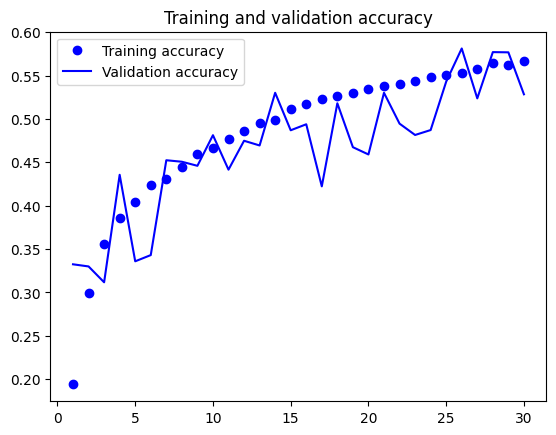

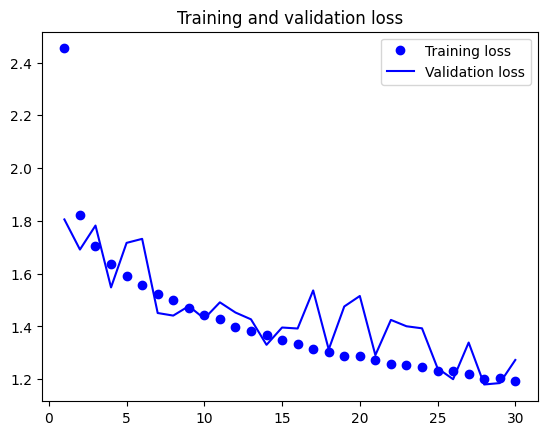

In [ ]:
accuracy_a0 = history_a0.history['accuracy']
val_accuracy_a0 = history_a0.history['val_accuracy']
loss_a0 = history_a0.history['loss']
val_loss_a0 = history_a0.history['val_loss']
epochs_a0 = range(1, len(accuracy_a0) + 1)

plt.plot(epochs_a0, accuracy_a0, 'bo', label='Training accuracy')
plt.plot(epochs_a0, val_accuracy_a0, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a0, loss_a0, 'bo', label='Training loss')
plt.plot(epochs_a0, val_loss_a0, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluace modelu

Vyhodnocení modelu na testovacích datech.

In [ ]:
test_loss, test_acc = model_a0.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 4ms/step - loss: 1.2573 - accuracy: 0.5435
Test accuracy: is 0.5434567928314209


#### Závěr

Jak se již předpokládalo, takto nevyladěný vícevrstvý perceptron nedosahuje dobrých výsledků. Všechny správnosti se pohybují okolo 50 - 55 %, což je pro klasifikační model velmi špatné. Z grafu lze vidět téměř žádný rozdíl mezi trénovací a generalizační chybou, **takže k přeučení nedošlo**. Avšak neuronová síť klasifikovala téměř 50% všech případů špatně. S přechodem na architektury konvolučních neuronových sítí se předpokládá značné zlepšení kvality.

Níže uvedená tabulka znázorňuje výsledky.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.5673    | 0.5284  | 0.5435   | 1.1938     | 1.2726   | 1.2573    |

### <a id="convnet1">Convolutional Neural Network (A1)</a>

Další architekturou je základní konvoluční neuronová síť. Konvoluční neuronové sítě byly vybrány, protože dobře zpracovávají obrazová data a jsou primárně používána pro úlohy zpracování obrazu. Základní konvoluční sítí se myslí posloupnost konvolučních a sdružovacích vrstev bez žádných dalších úprav jako je obohacení dat nebo přenesené učení. Již zde se očekává zlepšení oproti klasickému vícevrstvému perceptronu.

#### Vytvoření modelu

Zde je vidět následující architektura konvoluční neuronové sítě. Je složena z 3 konvolučních vrstev, 2 sdružovacích vrstev a klasifikační vrstvy. V konvolučních vrstvách se použije aktivační funkce `relu` a na klasifikační vrstvě opět funkce `softmax`.

Architektura:

* **Vstupní vrstva** - (64, 64, 3) tenzor
* **Normalizační vrstva** - 1/255
* **Konvoluční vrstva č. 1** - 16 filtrů 3x3
* **Pooling vrstva č. 1** - 2x2 stride
* **Konvoluční vrstva č. 2** - 32 filtrů 3x3
* **Pooling vrstva č. 2** - 2x2 stride
* **Konvoluční vrstva č. 3** - 64 filtrů 3x3
* **Flattening vrstva**
* **Klasifikační vrstva** - 10 tříd

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a1 = keras.Model(inputs=inputs, outputs=outputs)
model_a1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                      

#### Trénování modelu

Proces trénování konvoluční neuronové sítě

Výchozí nastavení je **30 epoch**. Při problémech s výpočetními náklady zkusit alespoň **6 epoch**.

Doba trénování:
* Google Colab A100 GPU - 29 sekund

In [ ]:
model_a1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a1 = model_a1.fit(
    train_set,
    epochs=30,
    validation_data=validation_set
    )

Epoch 1/30
148/148 [==============================] - 4s 8ms/step - loss: 1.6216 - accuracy: 0.3799 - val_loss: 1.1664 - val_accuracy: 0.5832
Epoch 2/30
148/148 [==============================] - 1s 5ms/step - loss: 1.2393 - accuracy: 0.5495 - val_loss: 1.3483 - val_accuracy: 0.4815
Epoch 3/30
148/148 [==============================] - 1s 5ms/step - loss: 1.0641 - accuracy: 0.6149 - val_loss: 1.2991 - val_accuracy: 0.5096
Epoch 4/30
148/148 [==============================] - 1s 5ms/step - loss: 0.9524 - accuracy: 0.6569 - val_loss: 1.0625 - val_accuracy: 0.6393
Epoch 5/30
148/148 [==============================] - 1s 5ms/step - loss: 0.8736 - accuracy: 0.6806 - val_loss: 0.7604 - val_accuracy: 0.7168
Epoch 6/30
148/148 [==============================] - 1s 5ms/step - loss: 0.8010 - accuracy: 0.7130 - val_loss: 0.7233 - val_accuracy: 0.7620
Epoch 7/30
148/148 [==============================] - 1s 5ms/step - loss: 0.7454 - accuracy: 0.7339 - val_loss: 0.7177 - val_accuracy: 0.7657
Epoch 

#### Vizualizace křivky ztrátové funkce a správnosti během trénování

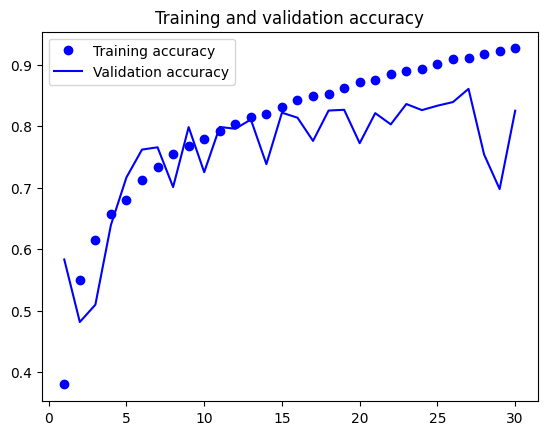

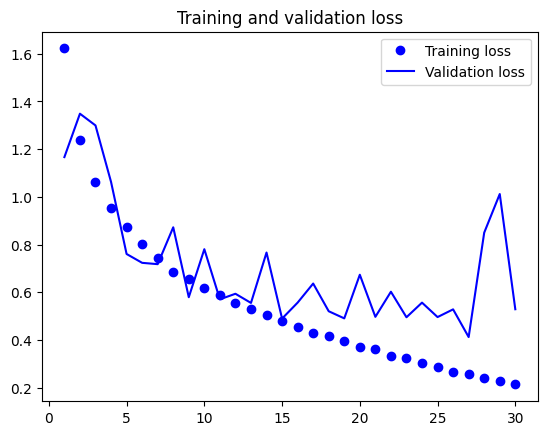

In [ ]:
accuracy_a1 = history_a1.history['accuracy']
val_accuracy_a1 = history_a1.history['val_accuracy']
loss_a1 = history_a1.history['loss']
val_loss_a1 = history_a1.history['val_loss']
epochs_a1 = range(1, len(accuracy_a1) + 1)

plt.plot(epochs_a1, accuracy_a1, 'bo', label='Training accuracy')
plt.plot(epochs_a1, val_accuracy_a1, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a1, loss_a1, 'bo', label='Training loss')
plt.plot(epochs_a1, val_loss_a1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluace modelu

Vyhodnocení modelu na testovacích datech.

In [ ]:
test_loss, test_acc = model_a1.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.8269
Test accuracy: is 0.826913595199585


#### Závěr

Níže uvedená tabulka znázorňuje výsledky architektury základních konvolučních neuronových sítí (A1). Jak je možné z tabulky i z grafu vidět, tato síť dosahuje mnohem lepších výsledků než vícevrstvý perceptron, přičemž obsahuje mnohonásobně méně parametrů. Správnost na trénovacích datech je velmi dobrá a to **92 %**, na validační a testovací množině je správnost **cca. 82 %**. I když tedy síť mnohem lépe klasifikuje jednotlivé případy ve všech množinách, došlo zde k **přeučení** neuronové sítě.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9264    | 0.8252  | 0.8269   | 0.2135     | 0.5288   | 0.5157    |


Nyní provedeme několik experimentů ladění hyperparemetrů sítě.

#### **Experiment 1 - Dropout**

Jako první experiment zkusíme do architektury neuronové sítě přidat regularizační techniku **Dropout**. Při dropoutu jsou některé neurony během trénování vyřazeny ze sítě a netrénuje se na nich. Výsledná reprezentace by poté měla být robustnější, protože je méně citlivá na konkrétní váhy a dokáže lépe generalizovat.


Při vytváření modelu do sítě přidáme vrstvu `keras.layers.Dropout` z knihovny keras.

https://keras.io/api/layers/regularization_layers/dropout/

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
# Regularizační vrstva Dropout
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model_a1 = keras.Model(inputs=inputs, outputs=outputs)
model_a1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                    

Výchozí nastavení je **30 epoch**. Při problémech s výpočetními náklady zkusit alespoň **8 epoch**.

Doba trénování:

* Google Colab A100 GPU - 27 sekund

In [ ]:
model_a1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a1 = model_a1.fit(
    train_set,
    epochs=30,
    validation_data=validation_set
    )

Epoch 1/30
148/148 [==============================] - 2s 6ms/step - loss: 1.6211 - accuracy: 0.3675 - val_loss: 1.3857 - val_accuracy: 0.4731
Epoch 2/30
148/148 [==============================] - 1s 5ms/step - loss: 1.2833 - accuracy: 0.5173 - val_loss: 1.4365 - val_accuracy: 0.4059
Epoch 3/30
148/148 [==============================] - 1s 5ms/step - loss: 1.1005 - accuracy: 0.5919 - val_loss: 0.9237 - val_accuracy: 0.6748
Epoch 4/30
148/148 [==============================] - 1s 5ms/step - loss: 0.9735 - accuracy: 0.6486 - val_loss: 0.8282 - val_accuracy: 0.6985
Epoch 5/30
148/148 [==============================] - 1s 5ms/step - loss: 0.8819 - accuracy: 0.6822 - val_loss: 0.9670 - val_accuracy: 0.6570
Epoch 6/30
148/148 [==============================] - 1s 5ms/step - loss: 0.8410 - accuracy: 0.6947 - val_loss: 0.6738 - val_accuracy: 0.7622
Epoch 7/30
148/148 [==============================] - 1s 5ms/step - loss: 0.7868 - accuracy: 0.7152 - val_loss: 1.2279 - val_accuracy: 0.5519
Epoch 

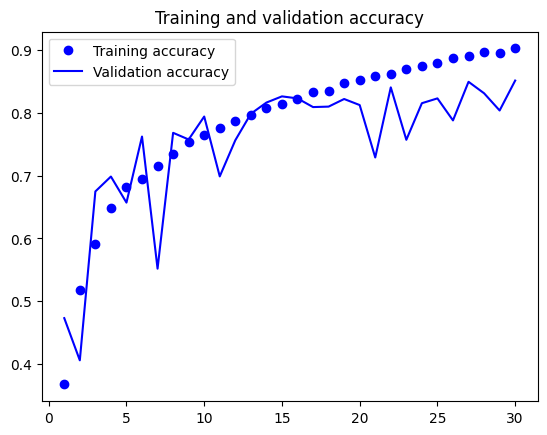

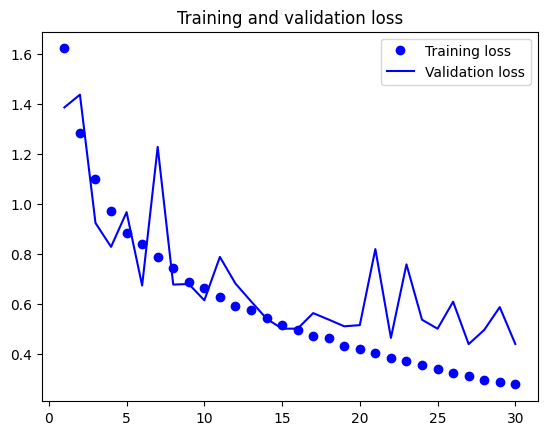

In [ ]:
accuracy_a1 = history_a1.history['accuracy']
val_accuracy_a1 = history_a1.history['val_accuracy']
loss_a1 = history_a1.history['loss']
val_loss_a1 = history_a1.history['val_loss']
epochs_a1 = range(1, len(accuracy_a1) + 1)

plt.plot(epochs_a1, accuracy_a1, 'bo', label='Training accuracy')
plt.plot(epochs_a1, val_accuracy_a1, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a1, loss_a1, 'bo', label='Training loss')
plt.plot(epochs_a1, val_loss_a1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a1.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.8590
Test accuracy: is 0.8590123653411865


##### Závěr experimentu 1

Přidáním regularizační techniky `Dropout(0.2)` se zlepšila validační správnost o cca. **3 %** a testovací správnost o cca. **3 %**. Zhoršila se pak trénovací správnost o cca. **2 %**. Jedná se o přijatelné zlepšení, které snížilo míru přeučení, avšak nijak výrazně. Zkoušel jsem různé hodnoty Dropout, avšak při velkých hodnotách parametru 0.4 - 0.9 se správnosti vždy zhoršily. Domnívám se, že výsledek techniky Dropout by byl lepší, kdyby celková architektura sítě byla větší.

Níže lze vidět tabulku s výsledky po aplikaci regularizace Dropout.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9024    | 0.8514  | 0.8590   | 0.2783     | 0.4401   | 0.4297    |

#### **Experiment 2 - Odstranění pooling vrstev**

Jako druhý experiment zkusíme z modelu odstranit sdružovací vrstvy. To by mělo mít za následek pomalejší trénování a více parametrů sítě. Zcela určitě by zde došlo k přeučení, takže použijeme i Dropout s parametrem `Dropout(0.5)`. V tomto experimentu se nepředpokládá zlepšení modelu, spíše má sloužit jako ukázka efektu odstranění sdružovacích vrstev.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model_a1 = keras.Model(inputs=inputs, outputs=outputs)
model_a1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 conv2d_26 (Conv2D)          (None, 58, 58, 64)        18496     
                                                                 
 flatten_12 (Flatten)        (None, 215296)            0         
                                                                 
 dropout_6 (Dropout)         (None, 215296)            0  

Síť má více parametrů, nastavíme tedy více epoch, aby měla síť více času na trénování. Výchozí nastavení je **50 epoch**. Při problémech s výpočetními náklady zkusit alespoň **10 epoch**.

Doba trénování:

* Google Colab A100 GPU - 1 minuta

In [ ]:
model_a1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a1 = model_a1.fit(
    train_set,
    epochs=50,
    validation_data=validation_set
    )

Epoch 1/50
148/148 [==============================] - 2s 10ms/step - loss: 1.7125 - accuracy: 0.3916 - val_loss: 1.1944 - val_accuracy: 0.5956
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 1.2448 - accuracy: 0.5697 - val_loss: 1.1876 - val_accuracy: 0.5669
Epoch 3/50
148/148 [==============================] - 1s 9ms/step - loss: 1.0434 - accuracy: 0.6353 - val_loss: 0.9127 - val_accuracy: 0.6602
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.8976 - accuracy: 0.6910 - val_loss: 0.9821 - val_accuracy: 0.6398
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.7753 - accuracy: 0.7352 - val_loss: 0.7340 - val_accuracy: 0.7398
Epoch 6/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6726 - accuracy: 0.7796 - val_loss: 0.7589 - val_accuracy: 0.7279
Epoch 7/50
148/148 [==============================] - 1s 9ms/step - loss: 0.5661 - accuracy: 0.8152 - val_loss: 0.6721 - val_accuracy: 0.7798
Epoch

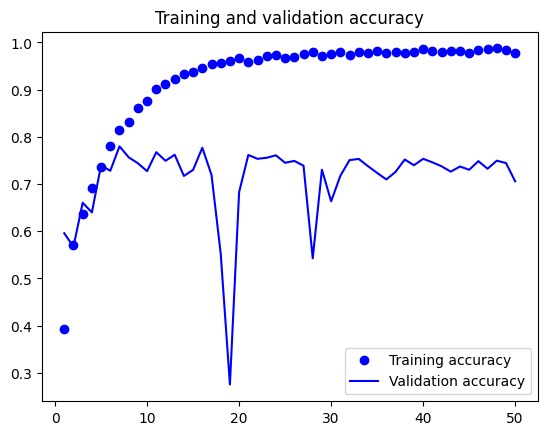

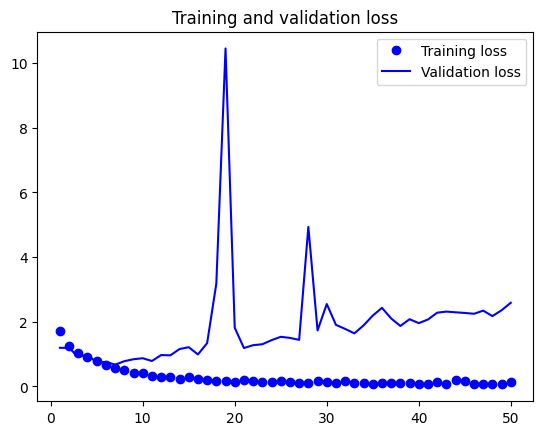

In [ ]:
accuracy_a1 = history_a1.history['accuracy']
val_accuracy_a1 = history_a1.history['val_accuracy']
loss_a1 = history_a1.history['loss']
val_loss_a1 = history_a1.history['val_loss']
epochs_a1 = range(1, len(accuracy_a1) + 1)

plt.plot(epochs_a1, accuracy_a1, 'bo', label='Training accuracy')
plt.plot(epochs_a1, val_accuracy_a1, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a1, loss_a1, 'bo', label='Training loss')
plt.plot(epochs_a1, val_loss_a1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a1.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 4ms/step - loss: 2.7382 - accuracy: 0.7057
Test accuracy: is 0.7056789994239807


##### Závěr experimentu 2

Jak lze vidět z grafu trénování, model je **extrémně přeučený**. Odstraněním sdružovacích vrstev a zvýšením epoch se správnost na trénovacích datech dostala až na cca. **97,7 %**. Avšak správnost na testovacích a validačních datech klesla na **70 %**. Model tedy velmi dobře klasifikuje na trénovacích datech a nedostatečně klasifikuje na nových případech. **Velmi se snížila generalizace modelu**, což je předpokládaný, ale ne dobrý výsledek. Lze tedy závěrem říci, že odstraňování sdružovacích vrstev není dobrý nápad.

Níže lze vidět tabulku s výsledky experimentu 2.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9770    | 0.7057  | 0.7057   | 0.1381     | 2.5874   | 2.7382    |

#### **Experiment 3 - Jeden konvoluční blok**

V dalším experimentu snížíme kapacitu modelu odstraněním vrstev. Výsledný model bude mít pouze jednu konvoluční a jednu sdružovací vrstvu. U konvoluční vrstvy zvětšíme počet filtrů a také velikost filtru. Aplikujeme také Dropout.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=128, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a1 = keras.Model(inputs=inputs, outputs=outputs)
model_a1.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 128)       9728      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 115200)            0         
                                                                 
 dropout_7 (Dropout)         (None, 115200)            0         
                                                          

Výchozí nastavení je **30 epoch**. Při problémech s výpočetními náklady zkusit alespoň **5 epoch**.

Doba trénování:

* Google Colab A100 GPU - 37 sekund

In [ ]:
model_a1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a1 = model_a1.fit(
    train_set,
    epochs=30,
    validation_data=validation_set
    )

Epoch 1/30
148/148 [==============================] - 2s 8ms/step - loss: 2.0152 - accuracy: 0.2677 - val_loss: 1.7128 - val_accuracy: 0.3165
Epoch 2/30
148/148 [==============================] - 1s 7ms/step - loss: 1.6296 - accuracy: 0.3988 - val_loss: 1.6834 - val_accuracy: 0.3131
Epoch 3/30
148/148 [==============================] - 1s 7ms/step - loss: 1.4633 - accuracy: 0.4721 - val_loss: 1.2726 - val_accuracy: 0.5684
Epoch 4/30
148/148 [==============================] - 1s 7ms/step - loss: 1.3447 - accuracy: 0.5164 - val_loss: 1.2745 - val_accuracy: 0.5286
Epoch 5/30
148/148 [==============================] - 1s 7ms/step - loss: 1.2576 - accuracy: 0.5567 - val_loss: 1.1799 - val_accuracy: 0.5716
Epoch 6/30
148/148 [==============================] - 1s 7ms/step - loss: 1.1899 - accuracy: 0.5830 - val_loss: 1.0811 - val_accuracy: 0.6188
Epoch 7/30
148/148 [==============================] - 1s 7ms/step - loss: 1.1390 - accuracy: 0.6003 - val_loss: 1.0650 - val_accuracy: 0.6183
Epoch 

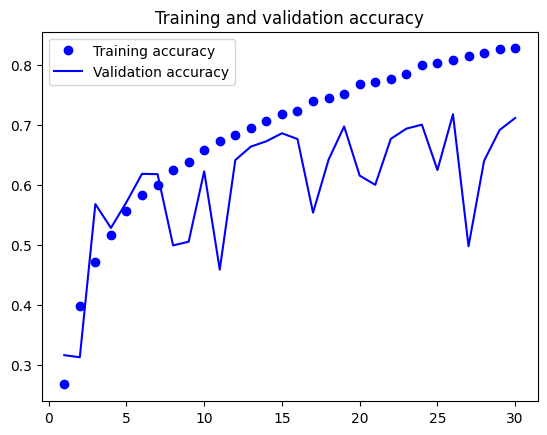

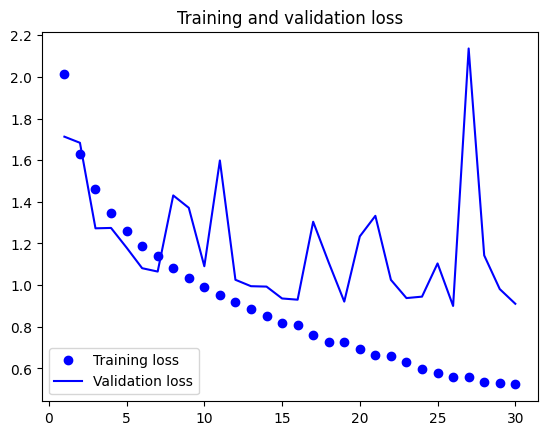

In [ ]:
accuracy_a1 = history_a1.history['accuracy']
val_accuracy_a1 = history_a1.history['val_accuracy']
loss_a1 = history_a1.history['loss']
val_loss_a1 = history_a1.history['val_loss']
epochs_a1 = range(1, len(accuracy_a1) + 1)

plt.plot(epochs_a1, accuracy_a1, 'bo', label='Training accuracy')
plt.plot(epochs_a1, val_accuracy_a1, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a1, loss_a1, 'bo', label='Training loss')
plt.plot(epochs_a1, val_loss_a1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a1.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 4ms/step - loss: 0.8991 - accuracy: 0.7151
Test accuracy: is 0.7150617241859436


###### Závěr experimentu 3

Na první pohled je ihned vidět, že výsledky tohoto experimentu jsou nedostačující v rámci dané úlohy. Oproti původní architektuře se všechny hodnoty zhoršily. Avšak tento experiment nám může ukázat, že tento dataset lze zpracovat již s takhle malou architekturou (1 konvoluční blok) a dosáhnout celkem slušných výsledků. To může být dobré zejména v případě, když **nemáme přístup k lepším výpočetním jednotkám**.

Níže lze vidět tabulku s výsledky experimentu 3.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.8277    | 0.7119  | 0.7151   | 0.5227     | 0.9103   | 0.8991    |

#### **Experiment 4 - Zvětšení modelu**

V posledním experimentu pro tuto architekturu se budeme snažit dosáhnout co nejlepších výsledků a model optimalizovat. Vytvoříme větší, robustnější model konvolučních neuronových sítí. Architektura tedy obsahuje celkem 4 konvoluční vrstvy, 3 pooling vrstvy a 1 klasifikační vrstvu. V rámci konvolučních vrstev se zvětšil počet filtrů, a nakonec se ještě aplikovala regularizační metoda Dropout, která nám v minulých experimentech přinesla zlepšení výsledků. Všechy konvoluční vrstvy kromě poslední mají za sebou pooling vrstvu.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model_a1 = keras.Model(inputs=inputs, outputs=outputs)
model_a1.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_19 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                    

Model je značně větší, takže nastavíme více epoch. Výchozí nastavení je **60 epoch**. Při problémech s výpočetními náklady zkusit alespoň **10 epoch**. V předchozích modelech byl vždy optimalizátor 'rmsprop', zkusíme tedy nyní 'adam'.

Doba trénování:

* Google Colab A100 GPU - 1 minuta 4 sekundy

In [ ]:
model_a1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history_a1 = model_a1.fit(
    train_set,
    epochs=60,
    validation_data=validation_set
    )

Epoch 1/60
148/148 [==============================] - 4s 10ms/step - loss: 1.5160 - accuracy: 0.3892 - val_loss: 1.2072 - val_accuracy: 0.5459
Epoch 2/60
148/148 [==============================] - 1s 6ms/step - loss: 1.0495 - accuracy: 0.6059 - val_loss: 0.9230 - val_accuracy: 0.6323
Epoch 3/60
148/148 [==============================] - 1s 6ms/step - loss: 0.8528 - accuracy: 0.6843 - val_loss: 0.7703 - val_accuracy: 0.7210
Epoch 4/60
148/148 [==============================] - 1s 6ms/step - loss: 0.7778 - accuracy: 0.7122 - val_loss: 0.6960 - val_accuracy: 0.7412
Epoch 5/60
148/148 [==============================] - 1s 6ms/step - loss: 0.6866 - accuracy: 0.7475 - val_loss: 0.6057 - val_accuracy: 0.7884
Epoch 6/60
148/148 [==============================] - 1s 6ms/step - loss: 0.6732 - accuracy: 0.7532 - val_loss: 0.6103 - val_accuracy: 0.7790
Epoch 7/60
148/148 [==============================] - 1s 6ms/step - loss: 0.5993 - accuracy: 0.7790 - val_loss: 0.5526 - val_accuracy: 0.8002
Epoch

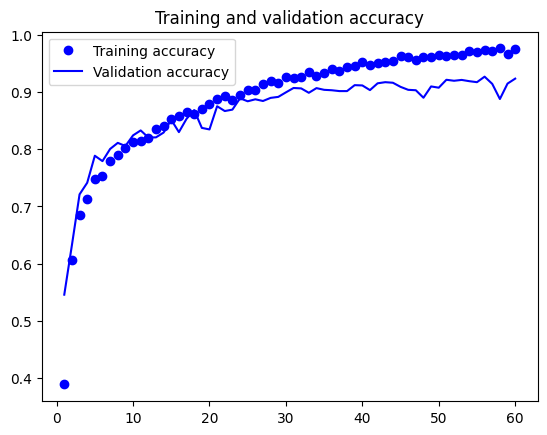

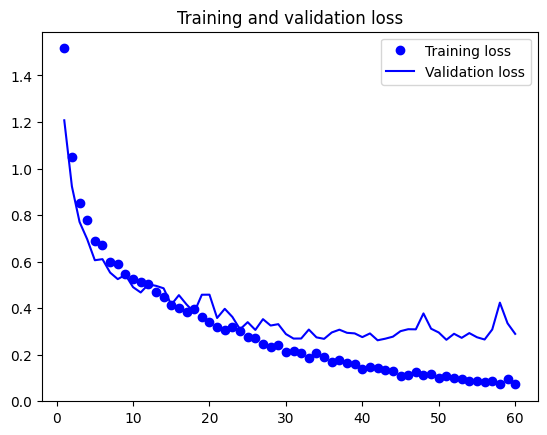

In [ ]:
accuracy_a1 = history_a1.history['accuracy']
val_accuracy_a1 = history_a1.history['val_accuracy']
loss_a1 = history_a1.history['loss']
val_loss_a1 = history_a1.history['val_loss']
epochs_a1 = range(1, len(accuracy_a1) + 1)

plt.plot(epochs_a1, accuracy_a1, 'bo', label='Training accuracy')
plt.plot(epochs_a1, val_accuracy_a1, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a1, loss_a1, 'bo', label='Training loss')
plt.plot(epochs_a1, val_loss_a1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a1.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 3ms/step - loss: 0.2777 - accuracy: 0.9190
Test accuracy: is 0.9190123677253723


##### Závěr experimentu 4

Z grafu je patrné, že výsledky jsou výborné. Správnost na trénovacích datech je velmi vysoká a to **97,5 %**. Na testovacích a validačních datech je poté správnost cca. **91,5 %**. Celkový výkon sítě se tedy zlepšil, na úkor výpočetních požadavků, protože máme více epoch a větší architekturu. Přeučení v síti sice je, **ale je relativně mnohem menší než v základním modelu**, a proto tento model lze považovat za optimální v rámci architektury A1.

Níže lze vidět tabulku s výsledky experimentu 4.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9750    | 0.9230  | 0.9190   | 0.0721     | 0.2892   | 0.2777    |

#### **Shrnutí - Convolutional Neural Network (A1)**

Jak jsme mohli vidět, konvoluční neuronové sítě jsou velmi mocným nástrojem pro zpracování obrazových dat. Zajisté lepší než klasické plně propojené dopředné neuronové sítě. Závěrem lze říci, že i takto velký dataset lze zpracovat relativně malým modelem (experiment 3) a dostat slušné výsledky. Avšak pokud chceme ještě lepší výsledky, je zapotřebí optimalizovat model a ladit hyperparametry (experiment 4). Výsledky, které podala základní architektura a příslušné experimenty, jsou v rámci této úlohy dostačující. Avšak jednoznačně nejlepších výsledků dosahuje robustnější a větší architektura z experimentu 4.

Níže lze vidět souhrnnou tabulku výsledků ze všech experimentů.

|                   | train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-------------------|-----------|---------|----------|------------|----------|-----------|
| a1 - basic        | 0.9264    | 0.8252  | 0.8269   | 0.2135     | 0.5288   | 0.5157    |
| a1 - experiment 1 | 0.9024    | 0.8514  | 0.8590   | 0.2783     | 0.4401   | 0.4297    |
| a1 - experiment 2 | **0.9770**    | 0.7057  | 0.7057   | 0.1381     | 2.5874   | 2.7382    |
| a1 - experiment 3 | 0.8277    | 0.7119  | 0.7151   | 0.5227     | 0.9103   | 0.8991    |
| a1 - experiment 4 | 0.9750    | **0.9230**  | **0.9190**   | **0.0721**     | **0.2892**   | **0.2777**    |

### <a id="convnet1">Convolutional Neural Network with Data Augmentation (A2)</a>

Nyní se přesuneme na další architekturu, konvoluční neuronové sítě s technikou obohacení dat, tj. data augmentation. Obohacení dat je přirozený způsob regularizace, kdy se při trénování použije více dat. Základní myšlenkou tohoto konceptu je vytvořit nová, umělá data z trénovací sady. Tuto architekturu má smysl testovat, jelikož by měla mít pozitivní vliv na výkon modelů. Jedná se tedy vlastně o nadstavbu předchozí architektury (A2).

#### Obohacení dat

Pomocí techniky obohacení dat můžeme vytvořit nová umělá data náhodnými transformacemi:
*   **Převracení**
*   **Otáčení**
*   **Zvětšování**
*   a další...

Je nutné vytvořit objekt, který tyto transformace zachytí pomocí funkce `keras.Sequential`.

https://keras.io/api/models/sequential/

https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.3),
    ]
)

Výsledek transformací:
* horizontální převrácení obrázků
* otáčení obrázků o 20 %
* přibližování obrázků o 30 %

Toto je základní nastavení, další hodnoty zkusíme při experimentech.

#### Vytvoření modelu


Vytvoříme základní model pro tuto architekturu. V tomto případě vezmeme původní model architektury A1 a přidáme k ní vytvořený objekt, který obsahuje transformace dat. Jelikož však budeme mít více trénovacích dat, tak je žádoucí architekturu zvětšit. Přidáme tedy další konvoluční a sdružovací vrstvu. Dále také přidáme regularizační techniku **Dropout** s parametrem `0.5`, jelikož máme robustnější architekturu.

Opět použijeme aktivační funkci `relu` na konvolučních vrstvách a funkci `softmax` pro finální klasifikaci.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))

# Provedeme techniku obohacení dat ještě před normalizací
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a2 = keras.Model(inputs=inputs, outputs=outputs)
model_a2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        4640      
                                                           

#### Trénování modelu

Proces trénování konvoluční neuronové sítě s obohacením dat.

Máme více trénovacích dat, využijeme tedy více epoch. Výchozí nastavení je **70 epoch**. Při problémech s výpočetními náklady zkusit alespoň **15 epoch**.

Doba trénování:
* Google Colab V100 GPU - 3 minuty

In [ ]:
model_a2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a2 = model_a2.fit(
    train_set,
    epochs=70,
    validation_data=validation_set
    )

Epoch 1/70
148/148 [==============================] - 5s 12ms/step - loss: 1.8318 - accuracy: 0.2743 - val_loss: 1.5671 - val_accuracy: 0.3753
Epoch 2/70
148/148 [==============================] - 2s 12ms/step - loss: 1.5014 - accuracy: 0.4272 - val_loss: 1.2812 - val_accuracy: 0.5195
Epoch 3/70
148/148 [==============================] - 2s 13ms/step - loss: 1.3032 - accuracy: 0.5251 - val_loss: 1.0433 - val_accuracy: 0.6538
Epoch 4/70
148/148 [==============================] - 3s 17ms/step - loss: 1.1699 - accuracy: 0.5765 - val_loss: 1.0959 - val_accuracy: 0.6022
Epoch 5/70
148/148 [==============================] - 2s 11ms/step - loss: 1.0713 - accuracy: 0.6095 - val_loss: 0.9045 - val_accuracy: 0.6778
Epoch 6/70
148/148 [==============================] - 2s 12ms/step - loss: 0.9896 - accuracy: 0.6369 - val_loss: 0.8834 - val_accuracy: 0.6699
Epoch 7/70
148/148 [==============================] - 2s 11ms/step - loss: 0.9326 - accuracy: 0.6603 - val_loss: 1.2612 - val_accuracy: 0.5721

#### Vizualizace křivky ztrátové funkce a správnosti během trénování

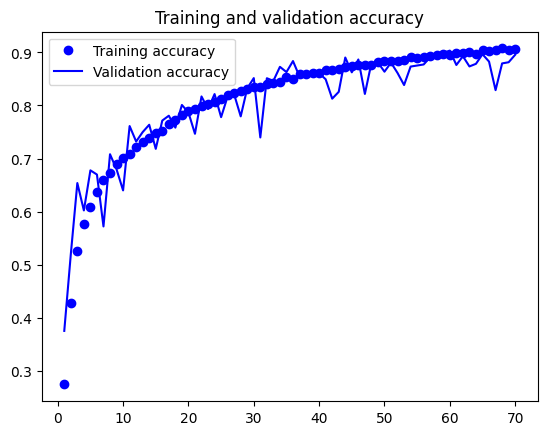

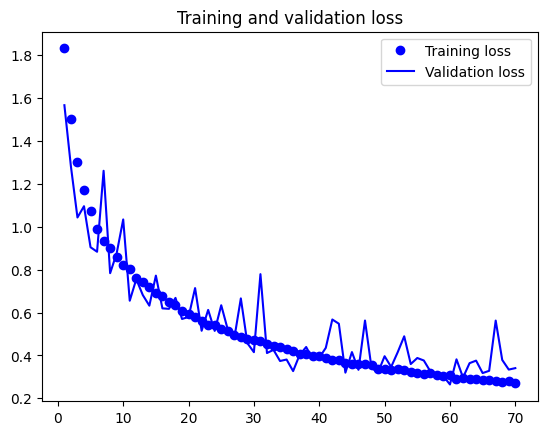

In [ ]:
accuracy_a2 = history_a2.history['accuracy']
val_accuracy_a2 = history_a2.history['val_accuracy']
loss_a2 = history_a2.history['loss']
val_loss_a2 = history_a2.history['val_loss']
epochs_a2 = range(1, len(accuracy_a2) + 1)

plt.plot(epochs_a2, accuracy_a2, 'bo', label='Training accuracy')
plt.plot(epochs_a2, val_accuracy_a2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a2, loss_a2, 'bo', label='Training loss')
plt.plot(epochs_a2, val_loss_a2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluace modelu

Vyhodnocení modelu na testovacích datech.

In [ ]:
test_loss, test_acc = model_a2.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 1s 21ms/step - loss: 0.2908 - accuracy: 0.9044
Test accuracy: is 0.9044444561004639


#### Závěr

Základní model této architektury byl velmi úspěšný. Správnost se pohybuje kolem **90 %** pro všechny datové množiny. **Z toho lze vyvodit, že model není přeučený a lépe generalizuje**. Přeučení ze základního modelu A1 bylo překonáno. Oproti základnímu modelu z A1 se zvýšila validační a testovací správnost, avšak lehce se snížila správnost trénovací. To je v pořádku, přidáním techniky obohacení dat se v trénovacích datech vytvoří šum a správnost skoro vždy klesne. Nevýhodou této techniky je delší trénovací doba a větší výpočetní náklady. Níže lze vidět tabulku s výsledky.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9071    | 0.8956  | 0.9044   | 0.2692     | 0.3405   | 0.2908    |

Nyní provedeme několik experimentů s touto architekturou.

#### **Experiment 1 - Vertikální převrácení**

V základním modelu této architektury jsme použili pouze horizontální převrácení obrázků v rámci techniky data augmentation. Nyní použijeme pouze vertikální převrácení a porovnáme výsledky modelů. Ostatní parametry ponecháme stejné.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('vertical'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.3),
    ]
)

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a2 = keras.Model(inputs=inputs, outputs=outputs)
model_a2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 32)        4640      
                                                           

Výchozí nastavení je **70 epoch**. Při problémech s výpočetními náklady zkusit alespoň **15 epoch**.

Doba trénování:
* Google Colab V100 GPU - 3 minuty 18 sekund

In [ ]:
model_a2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a2 = model_a2.fit(
    train_set,
    epochs=70,
    validation_data=validation_set
    )

Epoch 1/70
148/148 [==============================] - 4s 17ms/step - loss: 1.8127 - accuracy: 0.2904 - val_loss: 1.4386 - val_accuracy: 0.4200
Epoch 2/70
148/148 [==============================] - 2s 13ms/step - loss: 1.4817 - accuracy: 0.4411 - val_loss: 1.1946 - val_accuracy: 0.5543
Epoch 3/70
148/148 [==============================] - 2s 10ms/step - loss: 1.2699 - accuracy: 0.5326 - val_loss: 1.3334 - val_accuracy: 0.5235
Epoch 4/70
148/148 [==============================] - 2s 11ms/step - loss: 1.1344 - accuracy: 0.5871 - val_loss: 1.1095 - val_accuracy: 0.5706
Epoch 5/70
148/148 [==============================] - 2s 11ms/step - loss: 1.0425 - accuracy: 0.6183 - val_loss: 1.2685 - val_accuracy: 0.5331
Epoch 6/70
148/148 [==============================] - 2s 12ms/step - loss: 0.9891 - accuracy: 0.6374 - val_loss: 1.0224 - val_accuracy: 0.6269
Epoch 7/70
148/148 [==============================] - 3s 18ms/step - loss: 0.9471 - accuracy: 0.6527 - val_loss: 0.8669 - val_accuracy: 0.6852

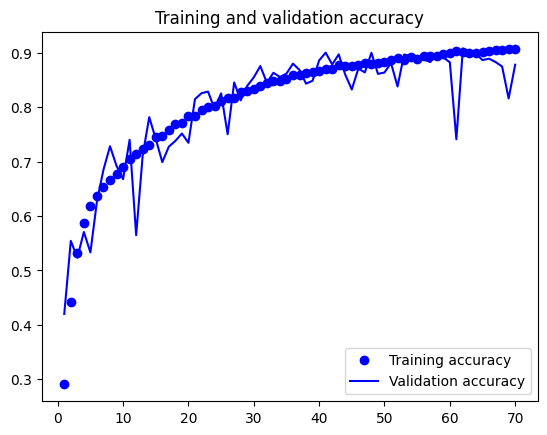

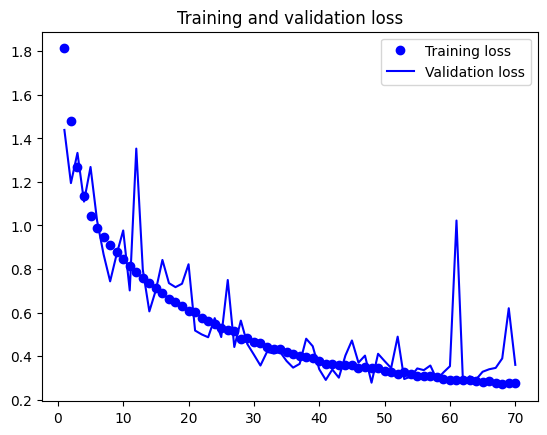

In [ ]:
accuracy_a2 = history_a2.history['accuracy']
val_accuracy_a2 = history_a2.history['val_accuracy']
loss_a2 = history_a2.history['loss']
val_loss_a2 = history_a2.history['val_loss']
epochs_a2 = range(1, len(accuracy_a2) + 1)

plt.plot(epochs_a2, accuracy_a2, 'bo', label='Training accuracy')
plt.plot(epochs_a2, val_accuracy_a2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a2, loss_a2, 'bo', label='Training loss')
plt.plot(epochs_a2, val_loss_a2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a2.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 6ms/step - loss: 0.3261 - accuracy: 0.8862
Test accuracy: is 0.8861728310585022


##### Závěr experimentu 1

Z grafu a výsledné tabulky lze vidět, že výsledky se prakticky neliší. Mírně klesla testovací správnost, ale všechny ostatní hodnoty jsou velmi podobné. **Nelze tedy z výsledků experimentu vyvodit rozdíl mezi vertikálním a horizontálním převrácením na výkonnost modelu**.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9076    | 0.8780  | 0.8862   | 0.2743     | 0.3598   | 0.3261    |

#### **Experiment 2 - Více transformací**

V tomto experimentu použijeme více transformací při technice obohacení dat. V minulých modelech jsme použili pouze náhodné převrácení, otáčení a zvětšování. Zde ještě přidáme techniky náhodné změny **jasu** a **kontrastu**. Tyto transformace nastavíme na hodnoty `0.2` a `0.15`. V předchozím experimentu jsme viděli, že rozdíl mezi vertikálním a horizontálním převrácení není, zkusíme  proto použít nyní oba najednou, tedy nastavíme hodnotu parametru na `horizontal_and_vertical`. U transformací otáčení a zvětšování nastavíme větší hodnoty než v předchozích modelech, tj. `0.5` a `0.4`. V tomto experimentu se snažíme zjistit, jak toto nastavení ovlivní kvalitu modelu.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.4),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.15)
    ]
)

Budeme mít k dispozici více trénovacích dat, je vhodné lehce zvětšit kapacitu sítě.

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a2 = keras.Model(inputs=inputs, outputs=outputs)
model_a2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                           

Máme více transformací, nastavíme tak více epoch. Výchozí nastavení je **80 epoch**. Při problémech s výpočetními náklady zkusit alespoň **15 epoch**.

Doba trénování:
* Google Colab V100 GPU - 4 minuty

In [ ]:
model_a2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a2 = model_a2.fit(
    train_set,
    epochs=80,
    validation_data=validation_set
    )

Epoch 1/80
148/148 [==============================] - 8s 21ms/step - loss: 1.8713 - accuracy: 0.2701 - val_loss: 1.5926 - val_accuracy: 0.3896
Epoch 2/80
148/148 [==============================] - 3s 15ms/step - loss: 1.5330 - accuracy: 0.4277 - val_loss: 1.4126 - val_accuracy: 0.4672
Epoch 3/80
148/148 [==============================] - 3s 18ms/step - loss: 1.3432 - accuracy: 0.4992 - val_loss: 1.0530 - val_accuracy: 0.5968
Epoch 4/80
148/148 [==============================] - 3s 17ms/step - loss: 1.2055 - accuracy: 0.5584 - val_loss: 1.4310 - val_accuracy: 0.5037
Epoch 5/80
148/148 [==============================] - 2s 14ms/step - loss: 1.1152 - accuracy: 0.5971 - val_loss: 0.9818 - val_accuracy: 0.6294
Epoch 6/80
148/148 [==============================] - 3s 18ms/step - loss: 1.0474 - accuracy: 0.6223 - val_loss: 1.0414 - val_accuracy: 0.6217
Epoch 7/80
148/148 [==============================] - 3s 19ms/step - loss: 0.9929 - accuracy: 0.6416 - val_loss: 0.7756 - val_accuracy: 0.7049

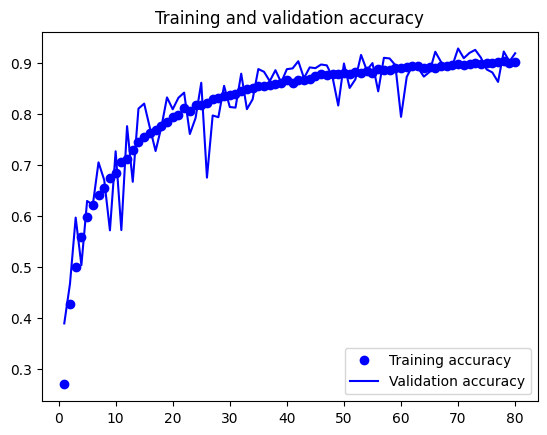

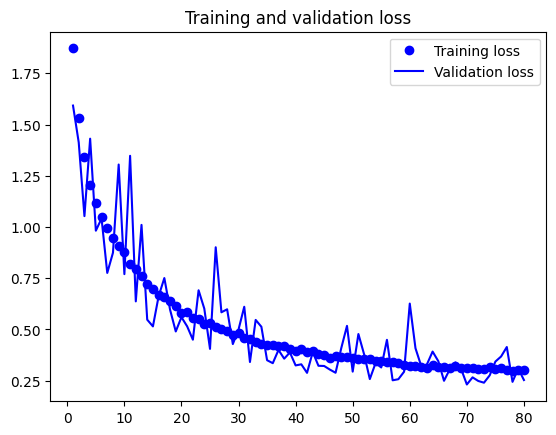

In [ ]:
accuracy_a2 = history_a2.history['accuracy']
val_accuracy_a2 = history_a2.history['val_accuracy']
loss_a2 = history_a2.history['loss']
val_loss_a2 = history_a2.history['val_loss']
epochs_a2 = range(1, len(accuracy_a2) + 1)

plt.plot(epochs_a2, accuracy_a2, 'bo', label='Training accuracy')
plt.plot(epochs_a2, val_accuracy_a2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a2, loss_a2, 'bo', label='Training loss')
plt.plot(epochs_a2, val_loss_a2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a2.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 0s 6ms/step - loss: 0.2433 - accuracy: 0.9207
Test accuracy: is 0.9207407236099243


##### Závěr experimentu 2

Oproti předchozímu experimentu se zvýšila jak validační správnost, tak i správnost na testovacích datech, cca. o **3,5 %**. Což je velmi dobrý výsledek. Správnost na trénovacích datech se poté prakticky nezměnila. **Vzniklo více šumu, avšak bylo nastaveno více epoch, trénování tedy probíhalo déle**. Je tedy otázka, jestli se tento experiment vyplatil. Pokud nebudeme brát v potaz výpočetní náklady, tak ano. V opačném případě je to na individuální rozhodnutí. Z grafu lze také vidět, že posledních pár epoch již na výsledek nemělo moc vliv a hodnoty oscilovaly kolem jednoho čísla. **Zvýšení správnosti relativně vůči navýšení velikost modelu a epoch tedy není příliš dobré, očekávali bychom lepší výsledek.**

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9024    | 0.9185  | 0.9207   | 0.2998     | 0.2528   | 0.2433    |

#### **Experiment 3 - Větší model**

V posledním experimentu zkusíme zvýšit počet filtrů na konvolučních vrstvách, model bude mít více parametrů a bude tak větší. Použijeme stejné nastavení transformací jako v předchozím experimentu a opět přidáme Dropout regularizaci. Poslední konvoluční vrstvě dám konvoluční filtr `5x5`.

V tomto experimentu se snažíme vytvořit co nejlepší model této architektury.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.4),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.15)
    ]
)

In [ ]:
inputs = keras.Input(shape=(64, 64, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=5, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a2 = keras.Model(inputs=inputs, outputs=outputs)
model_a2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 128)       73856     
                                                           

Máme více transformací a máme také větší model. Zkusíme tedy nastavit ještě více epoch a změníme optimalizátor na 'adam'. Výchozí nastavení je **100 epoch**. Při problémech s výpočetními náklady zkusit alespoň **15 epoch**.

Doba trénování:
* Google Colab V100 GPU - 7 minut

In [ ]:
model_a2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history_a2 = model_a2.fit(
    train_set,
    epochs=100,
    validation_data=validation_set
    )

Epoch 1/100
148/148 [==============================] - 15s 29ms/step - loss: 1.7129 - accuracy: 0.3252 - val_loss: 1.3314 - val_accuracy: 0.5133
Epoch 2/100
148/148 [==============================] - 4s 22ms/step - loss: 1.3203 - accuracy: 0.5005 - val_loss: 1.2028 - val_accuracy: 0.5691
Epoch 3/100
148/148 [==============================] - 3s 20ms/step - loss: 1.1180 - accuracy: 0.5924 - val_loss: 0.8278 - val_accuracy: 0.7084
Epoch 4/100
148/148 [==============================] - 3s 20ms/step - loss: 0.9911 - accuracy: 0.6371 - val_loss: 1.0400 - val_accuracy: 0.6306
Epoch 5/100
148/148 [==============================] - 4s 24ms/step - loss: 0.9068 - accuracy: 0.6786 - val_loss: 0.9379 - val_accuracy: 0.6583
Epoch 6/100
148/148 [==============================] - 4s 22ms/step - loss: 0.8209 - accuracy: 0.7060 - val_loss: 0.8503 - val_accuracy: 0.6921
Epoch 7/100
148/148 [==============================] - 3s 21ms/step - loss: 0.7933 - accuracy: 0.7149 - val_loss: 0.6915 - val_accuracy

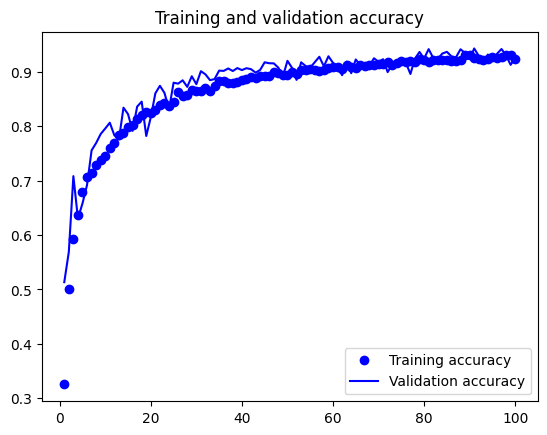

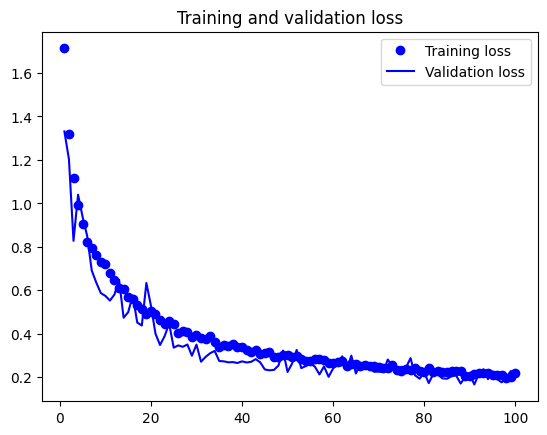

In [ ]:
accuracy_a2 = history_a2.history['accuracy']
val_accuracy_a2 = history_a2.history['val_accuracy']
loss_a2 = history_a2.history['loss']
val_loss_a2 = history_a2.history['val_loss']
epochs_a2 = range(1, len(accuracy_a2) + 1)

plt.plot(epochs_a2, accuracy_a2, 'bo', label='Training accuracy')
plt.plot(epochs_a2, val_accuracy_a2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a2, loss_a2, 'bo', label='Training loss')
plt.plot(epochs_a2, val_loss_a2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a2.evaluate(test_set)
print("Test accuracy: is", test_acc)

32/32 [==============================] - 1s 41ms/step - loss: 0.2110 - accuracy: 0.9291
Test accuracy: is 0.929135799407959


##### Závěr experimentu 3

V posledním experimentu jsme zvýšili kapacitu modelu a také zvýšili počet **epoch na 100**. Trénování trvalo 7 minut, tedy o dost více než všechna předchozí trénování. Výsledná trénovací správnost byla **92,5 %**, tj. lepší než v předchozím experimentu. Testovací a validační správnosti se ale moc nezlepšily, **cca. o 1 %**. Vzhledem k tomu, že jsme mnohonásobně zvýšili kapacitu modelu a dobu trénování, není tento výsledek až tak dobrý. Chtěli bychom dosáhnout ještě lepších výsledků. **Avšak i přes tento fakt, je výsledek velmi dobrý a tato síť velmi dobře klasifikuje vstupní obrázky.**

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9247    | 0.9262  | 0.9291   | 0.2211     | 0.2198   | 0.2110    |

#### **Shrnutí - Convolutional Neural Network with Data Augmentation (A2)**

**Cílem této architektury bylo překonat přeučení z klasických konvolučních neurnových sítí, a to se povedlo**. Ve všech případech byla testovací a validační správnost lepší než u modelů předchozí architektury. Často se pohybovalo kolem **90 %**, což je velmi dobrý výsledek. Tím lze považovat techniku obohacení dat za úspěšnou. Má však i své nevýhody. Musíme neustále zvětšovat kapacitu modelu a počet epoch kvůli většímu počtu trénovacích případů. To má za následek pomalejší trénování a vyšší výpočetní náklady. Další nevýhoda spočívá v zhoršení trénovací správnosti. Jelikož do trénovací množiny přidáváme nové, umělé případy, vytváří to šum a celková kvalita množiny se poté zhorší. Ovšem v rámci značného zlepšení generalizace modelu se to vyplatí.

Experiment 1 testoval rozdíl mezi vertikálním a horizontálním převrácení, kde se nenašel značný rozdíl. Experiment 2 zkoušel více transformací, což mělo za následek lehké zlepšení generalizace modelu. Experiment 3 se poté snažil optimalizovat model zvýšením kapacity, více transformacemi a více epochami, což se také povedlo. **Celkově lze tedy považovat výsledky této architektury za skvělé.**

V níže uvedené tabulce je možné vidět všechny výsledky experimentů v této architektuře.

|                   | train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-------------------|-----------|---------|----------|------------|----------|-----------|
| a2 - basic        | 0.9071    | 0.8956  | 0.9044   | 0.2692     | 0.3405   | 0.2908    |
| a2 - experiment 1 | 0.9076    | 0.8780   | 0.8862   | 0.2743     | 0.3598   | 0.3261    |
| a2 - experiment 2 | 0.9024    | 0.9185  | 0.9207   | 0.2998     | 0.2528   | 0.2433    |
| a2 - experiment 3 | **0.9247**    | **0.9262**  | **0.9291**   | **0.2211**     | **0.2198**   | **0.2110**    |

### <a id="convnet1">Convolutional Neural Network with Transfer Learning (A3)</a>

Poslední zkoumanou architekturou jsou konvoluční neuronové sítě s technikou přeneseného učení. **Přenesené učení** je technika strojového učení, která používá předem natrénovaný model. Tento model byl předtrénován na jiné, avšak související úloze. K předtrénování se používají obrovské datasety. Jsou v podstatě dva způsoby, jak použít techniku přeneseného učení:
* **přímo použít daný model**
* **feature extraction**
* **fine tunning**

V případě této práce budeme pracovat s variantou **feature extraction**. Cílem této architektury je použít existující model předtrénovaný na úloze klasifikace obrázků a využít ho pro náš dataset.

https://keras.io/guides/transfer_learning/

#### Feature Extraction

Feature extraction je metoda přeneseného učení, kde se využije konvoluční báze předtrénovaného modelu pro získání příznaků pro klasifikaci **(feature extraction)**. Konvoluční báze je zmrazená a její parametry jsou pevně dány z daného modelu. Nad konvoluční bází poté natrénujeme klasickou dopřednou klasifikační vrstvu.

Jako předtrénovaný model pro tuto úlohu vybereme model **ConvNeXtBase** z knihovny `keras.applications`. Jedná se o velký předtrénovaný model z roku 2020 natrénovaný na datasetu ImageNet. Parametry modelu:
* Size (MB) - 338.58
* Top-1 accuracy - 85.3 %
* Parameters - 88.5 MB

https://keras.io/api/applications/

https://keras.io/api/applications/convnext/#convnextbase-function

https://arxiv.org/abs/2201.03545

Při importu modelu nastavíme váhy modelu na váhy z trénování datasetu ImageNet, `weights='imagenet'`. Parametrem `include_top=False`, říkáme, že nechceme použít klasifikační vrstvu modelu, tu si natrénujeme sami. Na závěr je potřeba uvést jaké jsou rozměry našich obrázků parametrem `input_shape`.

In [ ]:
convolutional_base = keras.applications.convnext.ConvNeXtBase(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)

350926856/350926856 [==============================] - 11s 0us/step


In [ ]:
# Výpis parametrů modelu je moc velký, proto je zakomentován
# convolutional_base.summary()

Dále musíme natrénovat naši klasifikační vrstvu pro klasifikaci obrázků z eurosat datasetu. Je potřeba získat příznaky z ConvNeXtBase a použít je jako vstupy do trénování.

Použijeme funkci `extract_features_and_labels`, která nám extrahuje příznaky z ConvNeXtBase. Na nich poté natrénujeme naši klasifikační vrstvu.

Doba extrakce:
* Google Colab V100 GPU - 1 minuta 52 sekund

In [ ]:
def extract_features_and_labels(dataset):
    all_features = []
    all_labels = []

    # Použijeme obrázky a labely z našeho datasetu a natrénujeme je pomocí konvoluční báze ConvNeXtBase
    # Tímto procesem získáme natrénované příznaky pro naši klasifikaci
    for images, labels in dataset:
        preprocessed_images = keras.applications.convnext.preprocess_input(images)
        features = convolutional_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  extract_features_and_labels(train_set)
validation_features, validation_labels =  extract_features_and_labels(validation_set)
test_features, test_labels =  extract_features_and_labels(test_set)

3/3 [==============================] - 0s 54ms/step


In [ ]:
# Kontrolní výpis - velikost extrahovaných příznaků
train_features.shape

(18900, 2, 2, 1024)

#### Vytvoření modelu

Příznaky máme extrahované, je nyní potřeba natrénovat naši klasifikační vrstvu. Použijeme jednu skrytou vrstvu s 256 neurony a také využijeme regularizační techniky Dropout s parametrem `0.5`. Na výstupní vrstvě se opět klasifikuje do 1 z 10 tříd.

Důležité je změnit velikost tenzoru, aby odpovídal velikosti extrahovaných příznaků - `(2, 2, 1024)`.

In [ ]:
inputs = keras.Input(shape=(2, 2, 1024))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a3 = keras.Model(inputs, outputs)
model_a3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 2, 1024)]      0         
                                                                 
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1048832   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1051402 (4.01 MB)
Trainable params: 1051402 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Trénování modelu

Proces trénování klasifikační vrstvy metodou extrakce příznaků.

Výchozí nastavení je **20 epoch**. Při problémech s výpočetními náklady zkusit alespoň **3 epochy**.

Místo celého datasetu vložíme jako parametry extrahované příznaky a labely.

Doba trénování:
* Google Colab V100 GPU - 1 minuta

In [ ]:
model_a3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a3 = model_a3.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(
        validation_features,
        validation_labels
    )
)

Epoch 1/20
591/591 [==============================] - 3s 4ms/step - loss: 0.6654 - accuracy: 0.8164 - val_loss: 0.3317 - val_accuracy: 0.9035
Epoch 2/20
591/591 [==============================] - 2s 4ms/step - loss: 0.3858 - accuracy: 0.8954 - val_loss: 0.3092 - val_accuracy: 0.9141
Epoch 3/20
591/591 [==============================] - 2s 4ms/step - loss: 0.3144 - accuracy: 0.9180 - val_loss: 0.3007 - val_accuracy: 0.9274
Epoch 4/20
591/591 [==============================] - 3s 5ms/step - loss: 0.2747 - accuracy: 0.9287 - val_loss: 0.3316 - val_accuracy: 0.9336
Epoch 5/20
591/591 [==============================] - 3s 5ms/step - loss: 0.2471 - accuracy: 0.9395 - val_loss: 0.3564 - val_accuracy: 0.9296
Epoch 6/20
591/591 [==============================] - 2s 4ms/step - loss: 0.2214 - accuracy: 0.9449 - val_loss: 0.3951 - val_accuracy: 0.9299
Epoch 7/20
591/591 [==============================] - 2s 4ms/step - loss: 0.2026 - accuracy: 0.9508 - val_loss: 0.4270 - val_accuracy: 0.9353
Epoch 

#### Vizualizace křivky ztrátové funkce a správnosti během trénování

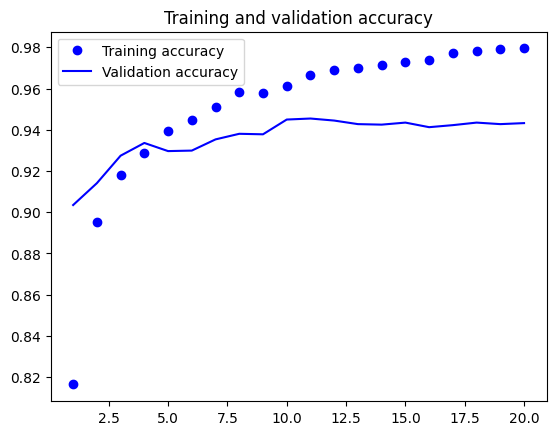

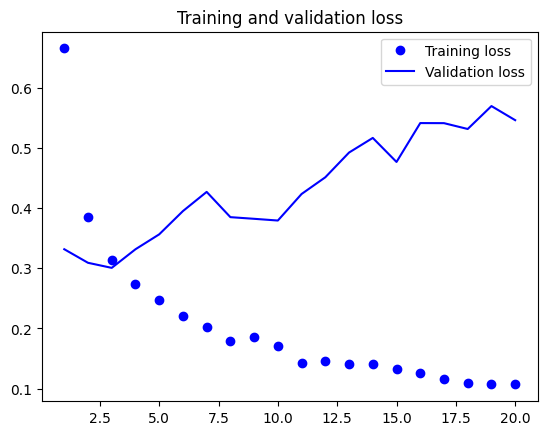

In [ ]:
accuracy_a3 = history_a3.history['accuracy']
val_accuracy_a3 = history_a3.history['val_accuracy']
loss_a3 = history_a3.history['loss']
val_loss_a3 = history_a3.history['val_loss']
epochs_a3 = range(1, len(accuracy_a3) + 1)

plt.plot(epochs_a3, accuracy_a3, 'bo', label='Training accuracy')
plt.plot(epochs_a3, val_accuracy_a3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a3, loss_a3, 'bo', label='Training loss')
plt.plot(epochs_a3, val_loss_a3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluace modelu

Vyhodnocení modelu na testovacích datech.

In [ ]:
test_loss, test_acc = model_a3.evaluate(test_features, test_labels)
print("Test accuracy: is", test_acc)

127/127 [==============================] - 0s 3ms/step - loss: 0.5680 - accuracy: 0.9395
Test accuracy: is 0.9395061731338501


#### Závěr

Zde je možné vidět výsledek základní architektury konvolučních sítí s technikou přeneseného učení, konkrétně s metodou extrakce příznaků. Výsledky jsou velmi dobré, zejména na trénovacích datech. Avšak i na testovacích a validačních datech získáváme doposud nejlepší výsledky. Model je lehce přeučený, avšak s jeho výbornými výsledky to není takový problém.

V této architektuře jsme vzali předtrénovaný model ConvNeXtBase a jeho zmraženou konvoluční bázi jsme použili pro extrakci příznaků z našich dat. Poté jsem tyto příznaky vzaly a natrénovaly podle nich naši klasifikační vrstvu na **97,9 %** trénovací správnosti.



| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9794    | 0.9432  | 0.9395   | 0.1076     | 0.5463   | 0.5680    |

Nyní provedeme několik experimentů s touto architekturou.

#### **Experiment 1 - Ostranění skryté vrstvy**


Z modelu odstraníme původní skrytou vrstvu s 256 neurony a porovnáme výsledky s předchozím modelem.

In [ ]:
inputs = keras.Input(shape=(2, 2, 1024))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a3 = keras.Model(inputs, outputs)
model_a3.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 2, 2, 1024)]      0         
                                                                 
 flatten_12 (Flatten)        (None, 4096)              0         
                                                                 
 dropout_9 (Dropout)         (None, 4096)              0         
                                                                 
 dense_29 (Dense)            (None, 10)                40970     
                                                                 
Total params: 40970 (160.04 KB)
Trainable params: 40970 (160.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Výchozí nastavení je **20 epoch**. Při problémech s výpočetními náklady zkusit alespoň **3 epochy**.

Doba trénování:
* Google Colab V100 GPU - 53 sekund

In [ ]:
model_a3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history_a3 = model_a3.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(
        validation_features,
        validation_labels
    )
)

Epoch 1/20
591/591 [==============================] - 5s 7ms/step - loss: 0.5365 - accuracy: 0.8404 - val_loss: 0.2703 - val_accuracy: 0.9227
Epoch 2/20
591/591 [==============================] - 2s 3ms/step - loss: 0.3036 - accuracy: 0.9108 - val_loss: 0.2660 - val_accuracy: 0.9299
Epoch 3/20
591/591 [==============================] - 2s 3ms/step - loss: 0.2593 - accuracy: 0.9267 - val_loss: 0.2674 - val_accuracy: 0.9301
Epoch 4/20
591/591 [==============================] - 2s 3ms/step - loss: 0.2470 - accuracy: 0.9317 - val_loss: 0.2535 - val_accuracy: 0.9351
Epoch 5/20
591/591 [==============================] - 2s 3ms/step - loss: 0.2372 - accuracy: 0.9349 - val_loss: 0.2521 - val_accuracy: 0.9412
Epoch 6/20
591/591 [==============================] - 3s 5ms/step - loss: 0.2126 - accuracy: 0.9443 - val_loss: 0.2676 - val_accuracy: 0.9393
Epoch 7/20
591/591 [==============================] - 2s 4ms/step - loss: 0.2118 - accuracy: 0.9432 - val_loss: 0.2843 - val_accuracy: 0.9393
Epoch 

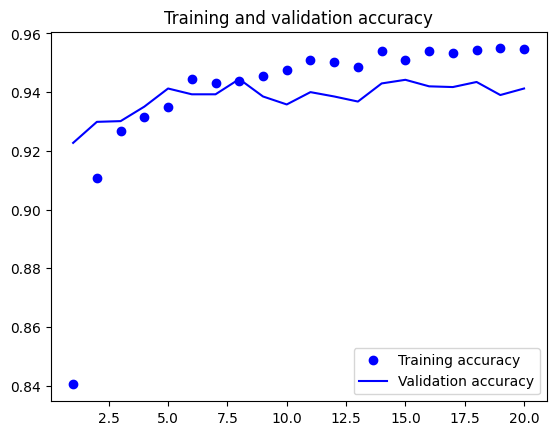

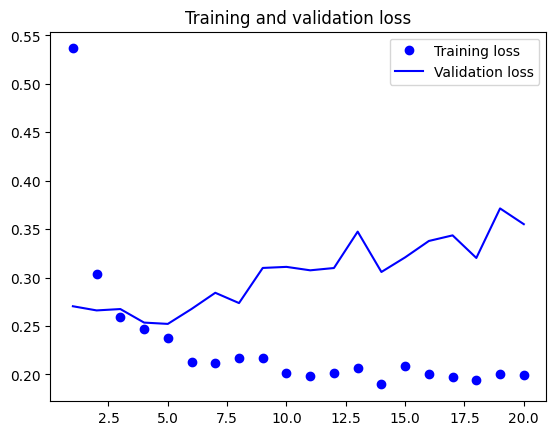

In [ ]:
accuracy_a3 = history_a3.history['accuracy']
val_accuracy_a3 = history_a3.history['val_accuracy']
loss_a3 = history_a3.history['loss']
val_loss_a3 = history_a3.history['val_loss']
epochs_a3 = range(1, len(accuracy_a3) + 1)

plt.plot(epochs_a3, accuracy_a3, 'bo', label='Training accuracy')
plt.plot(epochs_a3, val_accuracy_a3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a3, loss_a3, 'bo', label='Training loss')
plt.plot(epochs_a3, val_loss_a3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a3.evaluate(test_features, test_labels)
print("Test accuracy: is", test_acc)

127/127 [==============================] - 1s 6ms/step - loss: 0.3215 - accuracy: 0.9472
Test accuracy: is 0.9471604824066162


##### Závěr experimentu 1

Výsledek prvního experimentu je velmi dobrý. Výrazně jsme **snížili celkovou kapacitu modelu**, avšak kvalita se nijak zásadně nezhoršila. Lehce klesla trénovací správnost, avšak testovací správnost se zvýšila. Správnost na validačních datech je stejná.

Tento výsledek nám podává informace o tom, že **předchozí skrytá vrstva vlastně nebyla úplně potřeba**, výsledky jsou velmi podobné. Navíc se nám podařilo vytvořit model, který lépe generalizuje (**snížili jsem přeučení**). Trénování bylo kvůli snížení parametrů mnohem rychlejší, což je dobrá zpráva pro systémy s nižší výpočetní kapacitou.

Níže uvedená tabulka znázorňuje výsledky experimentu.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9548    | 0.9412  | 0.9472   | 0.1994     | 0.3551   | 0.3215    |

#### **Experiment 2 - Větší kapacita**

Do původního modelu architektury přidáme další 2 skryté vrstvy s 128 a 64 neurony. Výsledek porovnáme s předchozím experimentem.

In [ ]:
inputs = keras.Input(shape=(2, 2, 1024))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_a3 = keras.Model(inputs, outputs)
model_a3.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2, 2, 1024)]      0         
                                                                 
 flatten_13 (Flatten)        (None, 4096)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               1048832   
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 10)                650

Zvýšíme počet epoch kvůli většímu počtu parametrů. Výchozí nastavení je **30 epoch**. Při problémech s výpočetními náklady zkusit alespoň **3 epochy**. Zkusíme tentokrát použít optimalizátor 'adam'.

Doba trénování:
* Google Colab V100 GPU - 1 minuta 58 sekund

In [ ]:
model_a3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history_a3 = model_a3.fit(
    train_features,
    train_labels,
    epochs=30,
    validation_data=(
        validation_features,
        validation_labels
    )
)

Epoch 1/30
591/591 [==============================] - 6s 6ms/step - loss: 0.6154 - accuracy: 0.8153 - val_loss: 0.2809 - val_accuracy: 0.9170
Epoch 2/30
591/591 [==============================] - 3s 6ms/step - loss: 0.2752 - accuracy: 0.9195 - val_loss: 0.2892 - val_accuracy: 0.9210
Epoch 3/30
591/591 [==============================] - 3s 5ms/step - loss: 0.1914 - accuracy: 0.9434 - val_loss: 0.2700 - val_accuracy: 0.9249
Epoch 4/30
591/591 [==============================] - 3s 5ms/step - loss: 0.1499 - accuracy: 0.9581 - val_loss: 0.2414 - val_accuracy: 0.9348
Epoch 5/30
591/591 [==============================] - 3s 5ms/step - loss: 0.1142 - accuracy: 0.9651 - val_loss: 0.2696 - val_accuracy: 0.9405
Epoch 6/30
591/591 [==============================] - 4s 6ms/step - loss: 0.0968 - accuracy: 0.9713 - val_loss: 0.2801 - val_accuracy: 0.9420
Epoch 7/30
591/591 [==============================] - 3s 5ms/step - loss: 0.0795 - accuracy: 0.9769 - val_loss: 0.3031 - val_accuracy: 0.9368
Epoch 

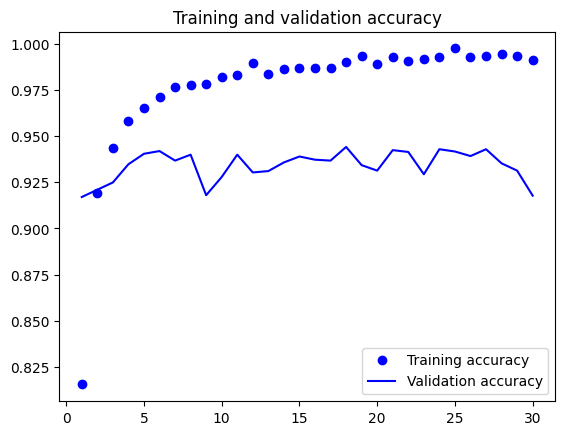

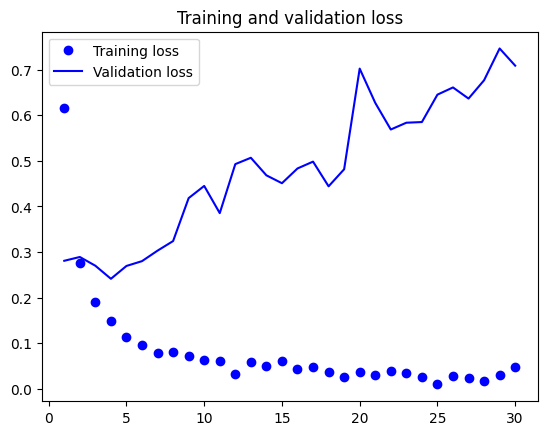

In [ ]:
accuracy_a3 = history_a3.history['accuracy']
val_accuracy_a3 = history_a3.history['val_accuracy']
loss_a3 = history_a3.history['loss']
val_loss_a3 = history_a3.history['val_loss']
epochs_a3 = range(1, len(accuracy_a3) + 1)

plt.plot(epochs_a3, accuracy_a3, 'bo', label='Training accuracy')
plt.plot(epochs_a3, val_accuracy_a3, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_a3, loss_a3, 'bo', label='Training loss')
plt.plot(epochs_a3, val_loss_a3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_a3.evaluate(test_features, test_labels)
print("Test accuracy: is", test_acc)

127/127 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.9198
Test accuracy: is 0.9197530746459961


##### Závěr experimentu 2

Jak je možné vidět z tabulky výsledků, dosáhli jsem v podstatě **100 % správnosti na trénovacích datech**. To znamená, že skoro všechny případy z trénovací množiny byly klasifikovány správně. Z grafu je ale patrné, že **model je značně přeučen**. Umí velmi dobře klasifikovat na trénovacích datech, ale má problémy s novými případy. **Oproti předchozímu experimentu tedy klesla schopnost generalizovat**.

| train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-----------|---------|----------|------------|----------|-----------|
| 0.9913    | 0.9178  | 0.9198   | 0.0491     | 0.7085   | 0.6910    |

#### **Shrnutí - Convolutional Neural Network with Transfer Learning (A3)**

Cílem této architektury bylo použít techniky **přeneseného učení** k natrénování na našem datasetu. Použili jsme předtrénovaný model **ConvNeXtBase** a pomocí metody **extrakce příznaků** jsme natrénovali jeho konvoluční bázi na našich obrázcích. Následně jsme použili extrahované příznaky pro trénování naší klasifikační vrstvy.

Výsledky architektury a příslušných experimentů jsou velmi dobré. **V tomto případě se již vždy pohybujeme nad hranicí 90 % správnosti a výše**. Provedli jsme celkem dva experimenty, v prvním jsme odstranili skrytou vrstvu sítě a zjistili jsme, že pro dobré výsledky není zapotřebí velká síť. Ve druhém experimentu jsme přidali do sítě více parametrů a přeučili jsme ji, avšak dosháli jsme správnosti **cca. 100 %** na trénovacích datech. Z následující tabulky lze vidět, že není experiment, kde by všechny hodnoty byly nejlepší. Nelze tedy přímo vybrat nejlepší model z této architektury. Avšak model z experimentu 1 vypadá obecně nejlépe.

Závěrem lze říci, že přenesené učení je velmi dobrou technikou pro klasifikaci obrazu a její použití na naši úlohu bylo úspěšné.

|                   | train_acc | val_acc | test_acc | train_loss | val_loss | test_loss |
|-------------------|-----------|---------|----------|------------|----------|-----------|
| a3 - basic        | 0.9794    | **0.9432**  | 0.9395   | 0.1076     | **0.5463**   | 0.5680    |
| a3 - experiment 1 | 0.9548    | 0.9412  | **0.9472**   | 0.1994     | 0.3551   | **0.3215**    |
| a3 - experiment 2 | **0.9913**    | 0.91784  | 0.9198   | **0.0491**     | 0.7085   | 0.6910    |

## Závěr

Tato kapitola obsahuje shrnutí výsledků, doporučení a zjištění z kapitoly modelování.

V rámci této semestrální práce se zpracovával dataset eurosat, který obsahuje 27 000 satelitních snímků. Cílem této semestrální práce bylo vytvořit několik architektur neuronových sítí a podrobit je úloze klasifikace obrazu. Nejdříve byla data načtena a rozdělena na trénovací, validační a testovací množiny. Následoval krátký průzkum dat a poté již proběhlo předzpracování dat. Při předzpracování dat se data transformovala do podoby vhodné pro úlohu klasifikace obrazu. Po předzpracování následovalo modelování, tj. vytvoření jednotlivých modelů, jejich trénování, evaluace a také ladění jejich hyperparametrů (experimenty).

V rámci modelování se zpracovávali celkem 4 architektury neurnových sítí:
* **vícevrstvý perceptron (A0)**
* **konvoluční neuronová síť (A1)**
* **konvoluční neuronová síť s obohacením dat (A2)**
* **konvoluční neuronová síť s přeneseným učením (A3)**

Vícevrstvý perceptron byl použit jako výchozí bod výzkumu a jeho výsledky jsou špatné. Hlavním cílem této práce bylo otestovat jednotlivé techniky konvolučních neuronových sítí. Všechny architektury konvolučních sítí dopadly dobře, některé lépe, některé hůře. Lze však tuto techniku považovat za perfektní nástroj zpracovávání obrazových dat. Zde lze vidět tabulky výsledků všech vytvořených modelů.

|                   | train_acc  | val_acc    | test_acc   | train_loss | val_loss   | test_loss  |
|-------------------|------------|------------|------------|------------|------------|------------|
| a0 - basic        | 0.5673     | 0.5284     | 0.5435     | 1.1938     | 1.2726     | 1.2573     |
| a1 - basic        | 0.9264     | 0.8252     | 0.8269     | 0.2135     | 0.5288     | 0.5157     |
| a1 - experiment 1 | 0.9024     | 0.8514     | 0.8590     | 0.2783     | 0.4401     | 0.4297     |
| a1 - experiment 2 | 0.9770     | 0.7057     | 0.7057     | 0.1381     | 2.5874     | 2.7382     |
| a1 - experiment 3 | 0.8277     | 0.7119     | 0.7151     | 0.5227     | 0.9103     | 0.8991     |
| a1 - experiment 4 | 0.9750     | 0.9230     | 0.9190     | 0.0721     | 0.2892     | 0.2777     |
| a2 - basic        | 0.9071     | 0.8956     | 0.9044     | 0.2692     | 0.3405     | 0.2908     |
| a2 - experiment 1 | 0.9076     | 0.8780     | 0.8862     | 0.2743     | 0.3598     | 0.3261     |
| a2 - experiment 2 | 0.9024     | 0.9185     | 0.9207     | 0.2998     | 0.2528     | 0.2433     |
| a2 - experiment 3 | 0.9247     | 0.9262     | 0.9291     | 0.2211     | **0.2198** | **0.2110** |
| a3 - basic        | 0.9794     | **0.9432** | 0.9395     | 0.1076     | 0.5463     | 0.5680     |
| a3 - experiment 1 | 0.9548     | 0.9412     | **0.9472** | 0.1994     | 0.3551     | 0.3215     |
| a3 - experiment 2 | **0.9913** | 0.9178    | 0.9198     | **0.0491** | 0.7085     | 0.6910     |

Nejlepších výsledků bezkonkurenčně dosáhly modely založené na přeneseném učení (A3), kde se hodnoty správností pohybovali okolo 95 %. Rozdíl mezi architekturami klasických konvolučních sítí a konvolučních sítí s technikou obohacení dat není zas tak velký, jak bylo předpokládáno. Avšak technika obohacení dat výrazně pomáhá s překonáním přeučení v síti.

Je těžké doporučit jednu architekturu, která by dosahovala nejlepších výsledků v každé situaci, záleží na kontextu. Pokud člověk má k dispozici vyšší výpočetní náklady, lze tvořit robustnější modely například s technikami obohacení dat. V případě, že má člověk přístup k méně výpočetním zdrojům a nebo nemá mnoho času na trénování, lze si také vytvořit slušně kvalitní síť, která bude dosahovat kvalitních výsledků s využitím konvolučních neuronových sítí.

Cíl semestrální práce se tedy povedlo splnit. Dataset byl otestovaný na několika architekturách a získané výsledky lze považovat za kvalitní.

## Souvislost s jinými semestrálními, případně kvalifikačními, pracemi zpracovávanými v minulosti nebo souběžně

Tato semestrální práce nemá textový ani věcný překryv, ani jinou věcnou souvislost, s jinými semestrálními nebo kvalifikačními pracemi, které jsem zpracovával.